# exp026
speed0モデルにセンサ特徴量を追加し、効果を確認

In [49]:
# import library
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles
import seaborn as sns
from tqdm.notebook import tqdm
import pathlib
import plotly
import plotly.express as px
import itertools
import lightgbm as lgb
from optuna.integration import lightgbm as optuna_lgb
import simdkalman
import optuna
import pyproj
from pyproj import Proj, transform
from sklearn import metrics
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix, accuracy_score

pd.set_option('display.max_rows', 100)

In [2]:
ro_th = 50 # 相対移動距離をもとにした異常値除去の閾値
rog_th = 10 # ground_truthをもとにした異常値除去の閾値

# ground_truthをもとにした異常値除去を行うcollection
rog_target = ['2021-04-22-US-SJC-1', '2021-04-29-US-SJC-2', '2021-04-28-US-SJC-1', '2021-04-22-US-SJC-2', '2021-04-29-US-SJC-3',
              '2021-04-28-US-MTV-1', '2021-04-29-US-MTV-1', '2021-03-16-US-RWC-2', '2021-04-28-US-MTV-2', '2021-04-29-US-MTV-2',
              '2021-04-26-US-SVL-2', '2021-03-10-US-SVL-1', '2021-04-26-US-SVL-1',
              '2021-04-21-US-MTV-1', '2021-04-28-US-MTV-1', '2021-04-29-US-MTV-1']

In [3]:
import ipynb_path

def get_nb_name():
    nb_path = ipynb_path.get()
    nb_name = nb_path.rsplit('/',1)[1].replace('.ipynb','')
    return nb_name

In [4]:
# directory setting
nb_name = get_nb_name()
INPUT = '../input/google-smartphone-decimeter-challenge'
OUTPUT = '../output/' + nb_name
os.makedirs(OUTPUT, exist_ok=True)

# utils

In [5]:
def get_train_score(df, gt):
    gt = gt.rename(columns={'latDeg':'latDeg_gt', 'lngDeg':'lngDeg_gt'})
    df = df.merge(gt, on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], how='inner')
    # calc_distance_error
    df['err'] = calc_haversine(df['latDeg_gt'], df['lngDeg_gt'], df['latDeg'], df['lngDeg'])
    # calc_evaluate_score
    df['phone'] = df['collectionName'] + '_' + df['phoneName']
    res = df.groupby('phone')['err'].agg([percentile50, percentile95])
    res['p50_p90_mean'] = (res['percentile50'] + res['percentile95']) / 2 
    score = res['p50_p90_mean'].mean()
    return score

In [6]:
def calc_haversine(lat1, lon1, lat2, lon2):
    """Calculates the great circle distance between two points
    on the earth. Inputs are array-like and specified in decimal degrees.
    """
    RADIUS = 6_367_000
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    dist = 2 * RADIUS * np.arcsin(a**0.5)
    return dist

In [7]:
def visualize_trafic(df, center, zoom=9):
    fig = px.scatter_mapbox(df,
                            
                            # Here, plotly gets, (x,y) coordinates
                            lat="latDeg",
                            lon="lngDeg",
                            
                            #Here, plotly detects color of series
                            color="phoneName",
                            labels="phoneName",
                            
                            zoom=zoom,
                            center=center,
                            height=600,
                            width=800)
    fig.update_layout(mapbox_style='stamen-terrain')
    fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
    fig.update_layout(title_text="GPS trafic")
    fig.show()
    
def visualize_collection(df, collection):
    target_df = df[df['collectionName']==collection].copy()
    lat_center = target_df['latDeg'].mean()
    lng_center = target_df['lngDeg'].mean()
    center = {"lat":lat_center, "lon":lng_center}
    
    visualize_trafic(target_df, center)

In [8]:
# ground_truth
def get_ground_truth():
    p = pathlib.Path(INPUT)
    gt_files = list(p.glob('train/*/*/ground_truth.csv'))

    gts = []
    for gt_file in gt_files:
        gts.append(pd.read_csv(gt_file))
    ground_truth = pd.concat(gts)

    return ground_truth

In [9]:
def percentile50(x):
    return np.percentile(x, 50)
def percentile95(x):
    return np.percentile(x, 95)

In [10]:
class train_result:
    def __init__(self, df):
        self.df = df
        self.gt = get_ground_truth()
        self.bl = pd.read_csv(INPUT + '/' + 'baseline_locations_train.csv')
        
        self.gt = self.gt.rename(columns={'latDeg':'latDeg_gt', 'lngDeg':'lngDeg_gt'})
        self.df = self.df.merge(self.gt, on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], how='inner')
        self.df['phone'] = self.df['collectionName'] + '_' + self.df['phoneName']
        self.df['err'] =  calc_haversine(self.df['latDeg_gt'], self.df['lngDeg_gt'], self.df['latDeg'], self.df['lngDeg'])
        
        self.phone_res = self.calc_err('phone')
        self.clc_res = self.calc_err('collectionName')
        self.phonename_res = self.calc_err('phoneName')
        
    def calc_err(self, by):
        res = self.df.groupby(by)['err'].agg([percentile50, percentile95])
        res['p50_p90_mean'] = (res['percentile50'] + res['percentile95']) / 2
        return res
    
    @property
    def score(self):
        return self.phone_res['p50_p90_mean'].mean()
    @property
    def raw_data(self):
        return self.df
    @property
    def err(self):
        return self.phone_res
    @property
    def collection_err(self):
        return self.clc_res
    @property
    def phonename_err(self):
        return self.phonename_res
    
    def viz_map(self, collection, show_gt=True, show_bl=True):
        tmp = self.df[self.df['collectionName']==collection][['collectionName', 'phoneName', 'latDeg', 'lngDeg']]
        tmp2 = self.df[self.df['collectionName']==collection][['collectionName', 'phoneName', 'latDeg_gt', 'lngDeg_gt']]
        tmp2 = tmp2.rename(columns={'latDeg_gt':'latDeg', 'lngDeg_gt':'lngDeg'})
        tmp2['phoneName'] = tmp2['phoneName'] + '_GT'
        tmp3 = self.bl[self.bl['collectionName']==collection][['collectionName', 'phoneName', 'latDeg', 'lngDeg']]
        tmp3['phoneName'] = tmp3['phoneName'] + '_BL'
        
        if show_gt:
            tmp = tmp.append(tmp2)
        if show_bl:
            tmp = tmp.append(tmp3)
        visualize_collection(tmp, collection)

In [11]:
def get_data():
    base_train = pd.read_csv(INPUT + '/' + 'baseline_locations_train.csv')
    base_test = pd.read_csv(INPUT + '/' + 'baseline_locations_test.csv')
    sample_sub = pd.read_csv(INPUT + '/' + 'sample_submission.csv')
    ground_truth = get_ground_truth()
    return base_train, base_test, sample_sub, ground_truth

# speed0の分類モデル（既存）

In [12]:
def add_features(df):
    for c,i in itertools.product(['latDeg', 'lngDeg', 'heightAboveWgs84EllipsoidM'], [1,2,3,-1,-2,-3]):
        col = c+ '_s' + str(i)
        df[col] = df[c].shift(i)
        df[col+'_diff'] = df[c] - df[col]
        df.loc[df['phone']!=df['phone'].shift(i), [col, col+'_diff']] = np.nan
    
    for c in ['latDeg', 'lngDeg', 'heightAboveWgs84EllipsoidM']:
        df[c+'_s1_diff_sum'] = df[c+'_s1_diff'].fillna(0) + df[c+'_s-1_diff'].fillna(0)
        df[c+'_s2_diff_sum'] = df[c+'_s1_diff_sum'] + df[c+'_s2_diff'].fillna(0) + df[c+'_s-2_diff'].fillna(0)
        df[c+'_s3_diff_sum'] = df[c+'_s2_diff_sum'] + df[c+'_s3_diff'].fillna(0) + df[c+'_s-3_diff'].fillna(0)
    
    return df

In [13]:
train, test, sub, gt = get_data()
train = train.merge(gt[['collectionName', 'phoneName', 'millisSinceGpsEpoch', 'speedMps']], on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], how='inner')
train.loc[train['speedMps']==0.0, 'isSpeed0'] = 1
train['isSpeed0'] = train['isSpeed0'].fillna(0)
train = add_features(train)
test = add_features(test)

In [14]:
target = 'isSpeed0'
not_use_cols = ['speedMps', 'collectionName', 'phoneName', 'phone', 'millisSinceGpsEpoch', 'latDeg', 'lngDeg', 'heightAboveWgs84EllipsoidM',
                'latDeg_s1', 'latDeg_s2', 'latDeg_s3', 'latDeg_s-1', 'latDeg_s-2',
                'latDeg_s-3', 'lngDeg_s1', 'lngDeg_s2', 'lngDeg_s3', 'lngDeg_s-1',
                'lngDeg_s-2', 'lngDeg_s-3', 'heightAboveWgs84EllipsoidM_s1',
                'heightAboveWgs84EllipsoidM_s2', 'heightAboveWgs84EllipsoidM_s3',
                'heightAboveWgs84EllipsoidM_s-1', 'heightAboveWgs84EllipsoidM_s-2',
                'heightAboveWgs84EllipsoidM_s-3', target]
features = [c for c in train.columns if c not in not_use_cols]

opt_params = {'objective': 'binary', 
              'learning_rate': 0.1, 
              'seed': 42, 
              'feature_pre_filter': False, 
              'lambda_l1': 5.430530747001109e-05, 
              'lambda_l2': 3.4066721259729875, 
              'num_leaves': 136, 
              'feature_fraction': 0.8999999999999999, 
              'bagging_fraction': 1.0, 
              'bagging_freq': 0, 
              'min_child_samples': 20, 
              'num_iterations': 20000, 
              'early_stopping_round': 100}

In [15]:
collections = train['collectionName'].unique()

oof = pd.DataFrame()
imp = pd.DataFrame()
test_preds = np.zeros(len(test))
n = len(collections)

for collection in collections:
    print('valid : ', collection)
    tr_idx = train[train['collectionName']!=collection].index
    vl_idx = train[train['collectionName']==collection].index
    tr_x, tr_y = train[features].iloc[tr_idx], train[target].iloc[tr_idx]
    vl_x, vl_y = train[features].iloc[vl_idx], train[target].iloc[vl_idx]
    tr_data = lgb.Dataset(tr_x, label=tr_y)
    vl_data = lgb.Dataset(vl_x, label=vl_y)
    
    model = lgb.train(opt_params, tr_data, valid_sets=[tr_data, vl_data],
                      num_boost_round=20000, early_stopping_rounds=100, verbose_eval=100)
    vl_pred = model.predict(vl_x, num_iteration=model.best_iteration)
    
    oof_tmp = train.iloc[vl_idx].copy()
    oof_tmp['pred'] = vl_pred
    oof = oof.append(oof_tmp)
    
    imp_tmp = pd.DataFrame()
    imp_tmp['feature'] = model.feature_name()
    imp_tmp['importance'] = model.feature_importance()
    imp_tmp['valid_collection'] = collection
    imp = imp.append(imp_tmp)
    
    pred = model.predict(test[features], num_iteration=model.best_iteration)
    test_preds += pred / n
test['pred'] = test_preds

valid :  2020-05-14-US-MTV-1
[LightGBM] [Info] Number of positive: 23249, number of negative: 104607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004869 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 127856, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181837 -> initscore=-1.503948
[LightGBM] [Info] Start training from score -1.503948
Training until validation scores don't improve for 100 rounds


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's binary_logloss: 0.0339981	valid_1's binary_logloss: 0.016154
[200]	training's binary_logloss: 0.0178696	valid_1's binary_logloss: 0.0155031
Early stopping, best iteration is:
[182]	training's binary_logloss: 0.0198739	valid_1's binary_logloss: 0.0153177
valid :  2020-05-14-US-MTV-2
[LightGBM] [Info] Number of positive: 23272, number of negative: 105723
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004662 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 128995, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.180410 -> initscore=-1.513572
[LightGBM] [Info] Start training from score -1.513572
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.0335415	valid_1's binary_logloss: 0.0316888
Early stopping, best iteration is:
[70]	training's binary_lo

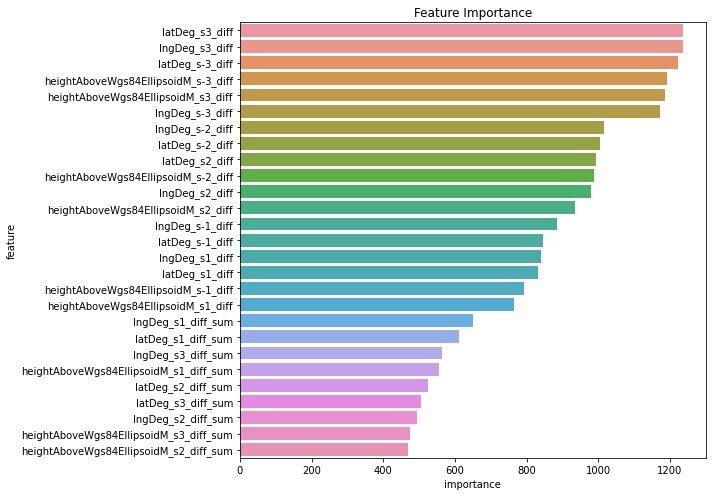

In [16]:
imp_mean = imp.groupby('feature').mean().reset_index()
plt.figure(figsize=(10, 7))
sns.barplot(x="importance", y="feature", data=imp_mean.sort_values(by="importance", ascending=False))
plt.title("Feature Importance")
plt.tight_layout()

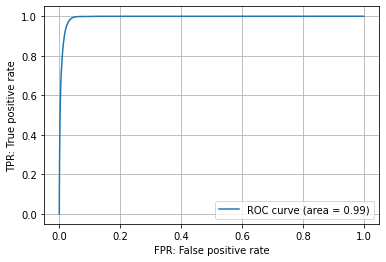

ROC_AUC :  0.9938574434199423


In [31]:
fpr, tpr, thresholds = roc_curve(oof['isSpeed0'], oof['pred'])
auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()
plt.show()
print('ROC_AUC : ', auc)

0.9648865151445771


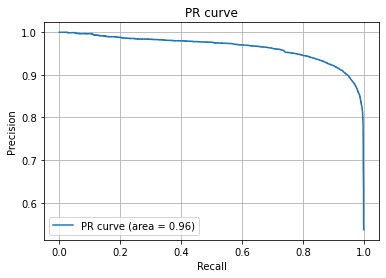

PR_AUC :  0.9648865151445771


In [34]:
precision, recall, thresholds = precision_recall_curve(oof['isSpeed0'], oof['pred'])

auc = metrics.auc(recall, precision)
print(auc)

plt.plot(recall, precision, label='PR curve (area = %.2f)'%auc)
plt.legend()
plt.title('PR curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()
print('PR_AUC : ', auc)

In [35]:
oof.loc[oof['pred']>0.5, 'pred2'] = 1
oof['pred2'] = oof['pred2'].fillna(0)
confusion_matrix(oof['isSpeed0'], oof['pred2'])

array([[105378,   2503],
       [  1216,  22245]])

<AxesSubplot:>

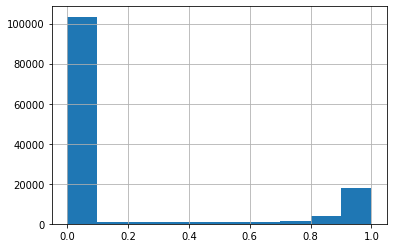

In [18]:
oof['pred'].hist()

In [19]:
os.makedirs(OUTPUT + '/speed0_pred/train', exist_ok=True)
phones = oof['phone'].unique()

for phone in phones:
    fig, axes = plt.subplots(figsize=(50, 20), nrows=2,sharex=True)
    tmp = oof[oof['phone']==phone].copy()

    axes[0].plot(tmp['millisSinceGpsEpoch'], tmp['speedMps'], label='speedMps')

    axes[1].plot(tmp['millisSinceGpsEpoch'], tmp['isSpeed0'], label='isSpeed0')
    axes[1].plot(tmp['millisSinceGpsEpoch'], tmp['pred'], label='pred')

    axes[0].legend(loc='lower right')
    axes[1].legend(loc='lower right')
    axes[0].grid(color='g', linestyle=':', linewidth=0.3)
    axes[1].grid(color='g', linestyle=':', linewidth=0.3)
    fig.suptitle(phone, fontsize=16)
    fig.savefig(OUTPUT + '/speed0_pred/train/' + phone + '.png')
    plt.close()

In [20]:
os.makedirs(OUTPUT + '/speed0_pred/test', exist_ok=True)
phones = test['phone'].unique()

for phone in phones:
    fig, axes = plt.subplots(figsize=(50, 20), nrows=2,sharex=True)
    tmp = test[test['phone']==phone].copy()

    axes[0].plot(tmp['millisSinceGpsEpoch'], tmp['pred'], label='pred')
    axes[1].plot(tmp['millisSinceGpsEpoch'], tmp['pred'], label='pred')

    axes[0].legend(loc='lower right')
    axes[0].grid(color='g', linestyle=':', linewidth=0.3)
    fig.suptitle(phone, fontsize=16)
    fig.savefig(OUTPUT + '/speed0_pred/test/' + phone + '.png')
    plt.close()

# センサ特徴量追加

In [36]:
def add_sensor_features(df, accel, gyro, mag):
    # phoneを追加
    df['phone'] = df['collectionName'] + '_' + df['phoneName']
    accel['phone'] = accel['collectionName'] + '_' + accel['phoneName']
    gyro['phone'] = gyro['collectionName'] + '_' + gyro['phoneName']
    mag['phone'] = mag['collectionName'] + '_' + mag['phoneName']
    
    # utc -> gps
    accel['millisSinceGpsEpoch'] = accel['utcTimeMillis'] - 315964800000 + 18000
    gyro['millisSinceGpsEpoch'] = gyro['utcTimeMillis'] - 315964800000 + 18000
    mag['millisSinceGpsEpoch'] = mag['utcTimeMillis'] - 315964800000 + 18000
    
    # resampling追加
    df['secondSinceGpsEpoch'] = df['millisSinceGpsEpoch'] // 1000
    accel['secondSinceGpsEpoch'] = accel['millisSinceGpsEpoch'] // 1000
    gyro['secondSinceGpsEpoch'] = gyro['millisSinceGpsEpoch'] // 1000
    mag['secondSinceGpsEpoch'] = mag['millisSinceGpsEpoch'] // 1000
    
    # clipping
    accel[['UncalAccelXMps2', 'UncalAccelYMps2', 'UncalAccelZMps2']] = accel.groupby('phone')['UncalAccelXMps2', 'UncalAccelYMps2', 'UncalAccelZMps2'].transform(lambda x: x.clip(x.quantile(0.001), x.quantile(0.999)))
    gyro[['UncalGyroXRadPerSec', 'UncalGyroYRadPerSec', 'UncalGyroZRadPerSec']] = gyro.groupby('phone')['UncalGyroXRadPerSec', 'UncalGyroYRadPerSec', 'UncalGyroZRadPerSec'].transform(lambda x: x.clip(x.quantile(0.001), x.quantile(0.999)))
    mag[['UncalMagXMicroT', 'UncalMagYMicroT', 'UncalMagZMicroT']] = mag.groupby('phone')['UncalMagXMicroT', 'UncalMagYMicroT', 'UncalMagZMicroT'].transform(lambda x: x.clip(x.quantile(0.001), x.quantile(0.999)))
    
    accel = accel.groupby(['phone', 'secondSinceGpsEpoch'])['UncalAccelXMps2', 'UncalAccelYMps2', 'UncalAccelZMps2'].agg(['mean', 'std']).reset_index()
    accel.columns = ['phone', 'secondSinceGpsEpoch', 'UncalAccelXMps2_mean', 'UncalAccelXMps2_std', 'UncalAccelYMps2_mean', 'UncalAccelYMps2_std', 'UncalAccelZMps2_mean', 'UncalAccelZMps2_std']
    gyro = gyro.groupby(['phone', 'secondSinceGpsEpoch'])['UncalGyroXRadPerSec', 'UncalGyroYRadPerSec', 'UncalGyroZRadPerSec'].agg(['mean', 'std']).reset_index()
    gyro.columns = ['phone', 'secondSinceGpsEpoch', 'UncalGyroXRadPerSec_mean', 'UncalGyroXRadPerSec_std', 'UncalGyroYRadPerSec_mean', 'UncalGyroYRadPerSec_std', 'UncalGyroZRadPerSec_mean', 'UncalGyroZRadPerSec_std' ]
    mag = mag.groupby(['phone', 'secondSinceGpsEpoch'])['UncalMagXMicroT', 'UncalMagYMicroT', 'UncalMagZMicroT'].agg(['mean', 'std']).reset_index()
    mag.columns = ['phone', 'secondSinceGpsEpoch', 'UncalMagXMicroT_mean', 'UncalMagXMicroT_std', 'UncalMagYMicroT_mean', 'UncalMagYMicroT_std', 'UncalMagZMicroT_mean', 'UncalMagZMicroT_std']
    
    df = df.merge(accel, on=['phone', 'secondSinceGpsEpoch'], how='left')
    df = df.merge(gyro, on=['phone', 'secondSinceGpsEpoch'], how='left')
    df = df.merge(mag, on=['phone', 'secondSinceGpsEpoch'], how='left')
    
    df.drop(['secondSinceGpsEpoch'], axis=1, inplace=True)
    
    return df

In [37]:
train, test, sub, gt = get_data()
accel_train = pd.read_csv(INPUT + '/prep/gnss/train/UncalAccel.csv')
gyro_train = pd.read_csv(INPUT + '/prep/gnss/train/UncalGyro.csv')
mag_train = pd.read_csv(INPUT + '/prep/gnss/train/UncalMag.csv')
accel_test = pd.read_csv(INPUT + '/prep/gnss/test/UncalAccel.csv')
gyro_test = pd.read_csv(INPUT + '/prep/gnss/test/UncalGyro.csv')
mag_test = pd.read_csv(INPUT + '/prep/gnss/test/UncalMag.csv')

train = train.merge(gt[['collectionName', 'phoneName', 'millisSinceGpsEpoch', 'speedMps']], on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], how='inner')
train.loc[train['speedMps']==0.0, 'isSpeed0'] = 1
train['isSpeed0'] = train['isSpeed0'].fillna(0)
train = add_features(train)
test = add_features(test)

train = add_sensor_features(train, accel_train, gyro_train, mag_train)
test = add_sensor_features(test, accel_test, gyro_test, mag_test)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_l

In [39]:
target = 'isSpeed0'
not_use_cols = ['speedMps', 'collectionName', 'phoneName', 'phone', 'millisSinceGpsEpoch', 'latDeg', 'lngDeg', 'heightAboveWgs84EllipsoidM',
                'latDeg_s1', 'latDeg_s2', 'latDeg_s3', 'latDeg_s-1', 'latDeg_s-2',
                'latDeg_s-3', 'lngDeg_s1', 'lngDeg_s2', 'lngDeg_s3', 'lngDeg_s-1',
                'lngDeg_s-2', 'lngDeg_s-3', 'heightAboveWgs84EllipsoidM_s1',
                'heightAboveWgs84EllipsoidM_s2', 'heightAboveWgs84EllipsoidM_s3',
                'heightAboveWgs84EllipsoidM_s-1', 'heightAboveWgs84EllipsoidM_s-2',
                'heightAboveWgs84EllipsoidM_s-3', target]
features = [c for c in train.columns if c not in not_use_cols]

opt_params = {'objective': 'binary', 
              'learning_rate': 0.1, 
              'seed': 42, 
              'feature_pre_filter': False, 
              'lambda_l1': 5.430530747001109e-05, 
              'lambda_l2': 3.4066721259729875, 
              'num_leaves': 136, 
              'feature_fraction': 0.8999999999999999, 
              'bagging_fraction': 1.0, 
              'bagging_freq': 0, 
              'min_child_samples': 20, 
              'num_iterations': 20000, 
              'early_stopping_round': 100}

In [41]:
collections = train['collectionName'].unique()

oof = pd.DataFrame()
imp = pd.DataFrame()
test_preds = np.zeros(len(test))
n = len(collections)

for collection in collections:
    print('valid : ', collection)
    tr_idx = train[train['collectionName']!=collection].index
    vl_idx = train[train['collectionName']==collection].index
    tr_x, tr_y = train[features].iloc[tr_idx], train[target].iloc[tr_idx]
    vl_x, vl_y = train[features].iloc[vl_idx], train[target].iloc[vl_idx]
    tr_data = lgb.Dataset(tr_x, label=tr_y)
    vl_data = lgb.Dataset(vl_x, label=vl_y)
    
    model = lgb.train(opt_params, tr_data, valid_sets=[tr_data, vl_data],
                      num_boost_round=20000, early_stopping_rounds=100, verbose_eval=100)
    vl_pred = model.predict(vl_x, num_iteration=model.best_iteration)
    
    oof_tmp = train.iloc[vl_idx].copy()
    oof_tmp['pred'] = vl_pred
    oof = oof.append(oof_tmp)
    
    imp_tmp = pd.DataFrame()
    imp_tmp['feature'] = model.feature_name()
    imp_tmp['importance'] = model.feature_importance()
    imp_tmp['valid_collection'] = collection
    imp = imp.append(imp_tmp)
    
    pred = model.predict(test[features], num_iteration=model.best_iteration)
    test_preds += pred / n
test['pred'] = test_preds

valid :  2020-05-14-US-MTV-1


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] Number of positive: 23249, number of negative: 104607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007971 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11475
[LightGBM] [Info] Number of data points in the train set: 127856, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181837 -> initscore=-1.503948
[LightGBM] [Info] Start training from score -1.503948
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.00516721	valid_1's binary_logloss: 0.0132107
[200]	training's binary_logloss: 0.0014109	valid_1's binary_logloss: 0.0111878
[300]	training's binary_logloss: 0.000672873	valid_1's binary_logloss: 0.0108959
[400]	training's binary_logloss: 0.000411296	valid_1's binary_logloss: 0.0109051
[500]	training's binary_logloss: 0.000286912	valid_1's binary_logloss: 0.0108706
Early stopping, best iteration is:
[

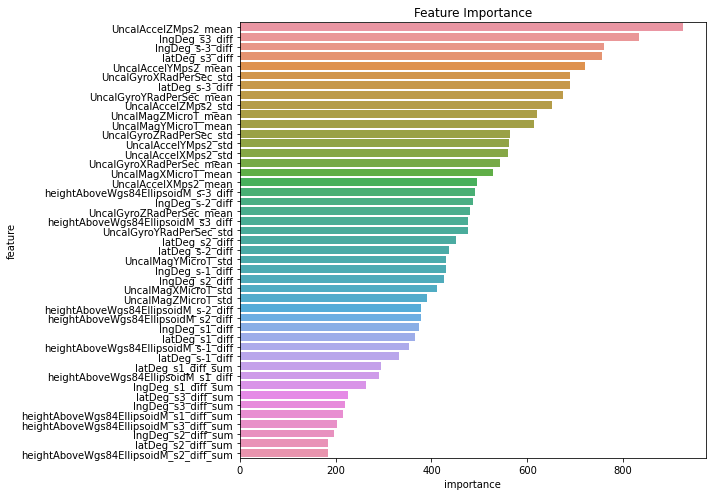

In [42]:
imp_mean = imp.groupby('feature').mean().reset_index()
plt.figure(figsize=(10, 7))
sns.barplot(x="importance", y="feature", data=imp_mean.sort_values(by="importance", ascending=False))
plt.title("Feature Importance")
plt.tight_layout()

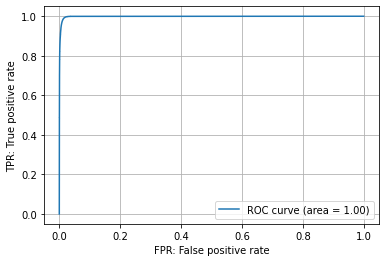

ROC_AUC :  0.9986916645401553


In [43]:
fpr, tpr, thresholds = roc_curve(oof['isSpeed0'], oof['pred'])
auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()
plt.show()
print('ROC_AUC : ', auc)

0.9926635718130152


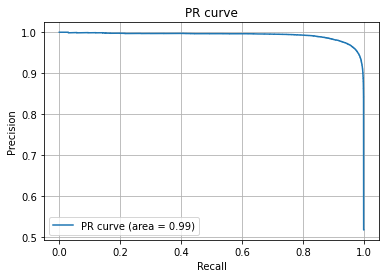

PR_AUC :  0.9926635718130152


In [44]:
precision, recall, thresholds = precision_recall_curve(oof['isSpeed0'], oof['pred'])

auc = metrics.auc(recall, precision)
print(auc)

plt.plot(recall, precision, label='PR curve (area = %.2f)'%auc)
plt.legend()
plt.title('PR curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()
print('PR_AUC : ', auc)

In [45]:
oof.loc[oof['pred']>0.5, 'pred2'] = 1
oof['pred2'] = oof['pred2'].fillna(0)
confusion_matrix(oof['isSpeed0'], oof['pred2'])

array([[106977,    904],
       [   767,  22694]])

<AxesSubplot:>

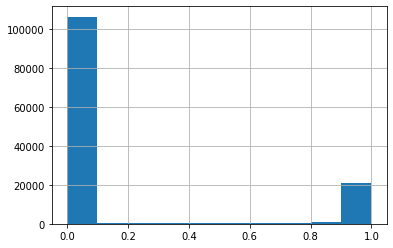

In [46]:
oof['pred'].hist()

In [47]:
os.makedirs(OUTPUT + '/speed0_pred_add_sensor/train', exist_ok=True)
phones = oof['phone'].unique()

for phone in phones:
    fig, axes = plt.subplots(figsize=(50, 20), nrows=2,sharex=True)
    tmp = oof[oof['phone']==phone].copy()

    axes[0].plot(tmp['millisSinceGpsEpoch'], tmp['speedMps'], label='speedMps')

    axes[1].plot(tmp['millisSinceGpsEpoch'], tmp['isSpeed0'], label='isSpeed0')
    axes[1].plot(tmp['millisSinceGpsEpoch'], tmp['pred'], label='pred')

    axes[0].legend(loc='lower right')
    axes[1].legend(loc='lower right')
    axes[0].grid(color='g', linestyle=':', linewidth=0.3)
    axes[1].grid(color='g', linestyle=':', linewidth=0.3)
    fig.suptitle(phone, fontsize=16)
    fig.savefig(OUTPUT + '/speed0_pred_add_sensor/train/' + phone + '.png')
    plt.close()

In [48]:
os.makedirs(OUTPUT + '/speed0_pred_add_sensor/test', exist_ok=True)
phones = test['phone'].unique()

for phone in phones:
    fig, axes = plt.subplots(figsize=(50, 20), nrows=2,sharex=True)
    tmp = test[test['phone']==phone].copy()

    axes[0].plot(tmp['millisSinceGpsEpoch'], tmp['pred'], label='pred')
    axes[1].plot(tmp['millisSinceGpsEpoch'], tmp['pred'], label='pred')

    axes[0].legend(loc='lower right')
    axes[0].grid(color='g', linestyle=':', linewidth=0.3)
    fig.suptitle(phone, fontsize=16)
    fig.savefig(OUTPUT + '/speed0_pred_add_sensor/test/' + phone + '.png')
    plt.close()

In [55]:
for th in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
    train_sp0_pred = oof[['collectionName', 'phoneName', 'millisSinceGpsEpoch', 'pred', 'isSpeed0']].copy()
    train_sp0_pred['pred2'] = np.nan
    train_sp0_pred.loc[train_sp0_pred['pred']>th, 'pred2'] = 1
    train_sp0_pred['pred2'] = train_sp0_pred['pred2'].fillna(0)
    acc = accuracy_score(train_sp0_pred['isSpeed0'], train_sp0_pred['pred2'])
    print(th, acc)

0.1 0.9845441671361789
0.2 0.9866150964657154
0.3 0.9873460126996696
0.4 0.9875439691796988
0.5 0.9872774893027364
0.6 0.9867673706811225
0.7 0.9855644043794064
0.8 0.9830823346682707
0.9 0.9774481886982077


In [88]:
th=0.5
tmp = oof[['collectionName', 'phoneName', 'millisSinceGpsEpoch', 'pred', 'isSpeed0']].copy()
tmp['phone'] = tmp['collectionName'] + '_' + tmp['phoneName']
tmp['pred2'] = np.nan
tmp.loc[tmp['pred']>th, 'pred2'] = 1
tmp['pred2'] = tmp['pred2'].fillna(0)
print('org : ', accuracy_score(tmp['isSpeed0'], tmp['pred2']))

org :  0.9872774893027364


In [87]:
tmp.loc[(tmp['phone']==tmp['phone'].shift(1)) & (tmp['phone']==tmp['phone'].shift(-1)) &
        (tmp['pred2']==0) & (tmp['pred2'].shift(1)==1) & (tmp['pred2'].shift(-1)==1), 'pred2'] = 1
print('1に挟まれた0を反転 : ', accuracy_score(tmp['isSpeed0'], tmp['pred2']))

1に挟まれた0を反転 :  0.9881378386197865


In [78]:
os.makedirs(OUTPUT + '/speed0_pred_add_sensor_othello/train', exist_ok=True)
phones = tmp['phone'].unique()

for phone in phones:
    fig, axes = plt.subplots(figsize=(50, 20), nrows=2,sharex=True)
    tmp2 = tmp[tmp['phone']==phone].copy()

    axes[0].plot(tmp2['millisSinceGpsEpoch'], tmp2['pred'], label='speedMps')

    axes[1].plot(tmp2['millisSinceGpsEpoch'], tmp2['isSpeed0'], label='isSpeed0')
    axes[1].plot(tmp2['millisSinceGpsEpoch'], tmp2['pred2'], label='pred')

    axes[0].legend(loc='lower right')
    axes[1].legend(loc='lower right')
    axes[0].grid(color='g', linestyle=':', linewidth=0.3)
    axes[1].grid(color='g', linestyle=':', linewidth=0.3)
    fig.suptitle(phone, fontsize=16)
    fig.savefig(OUTPUT + '/speed0_pred_add_sensor_othello/train/' + phone + '.png')
    plt.close()

In [93]:
train_sp0_pred = oof[['collectionName', 'phoneName', 'millisSinceGpsEpoch', 'pred']].copy()
test_sp0_pred = test[['collectionName', 'phoneName', 'millisSinceGpsEpoch', 'pred']].copy()

train_sp0_pred['phone'] = train_sp0_pred['collectionName'] + '_' + train_sp0_pred['phoneName']
test_sp0_pred['phone'] = test_sp0_pred['collectionName'] + '_' + test_sp0_pred['phoneName']

train_sp0_pred['isSpeed0'] = 0
test_sp0_pred['isSpeed0'] = 0
train_sp0_pred.loc[train_sp0_pred['pred']>0.5, 'isSpeed0'] = 1
test_sp0_pred.loc[test_sp0_pred['pred']>0.5, 'isSpeed0'] = 1

print('acc : ', accuracy_score(oof['isSpeed0'], train_sp0_pred['isSpeed0']))

train_sp0_pred.loc[(train_sp0_pred['phone']==train_sp0_pred['phone'].shift(1)) & (train_sp0_pred['phone']==train_sp0_pred['phone'].shift(-1)) &
                   (train_sp0_pred['isSpeed0']==0) & (train_sp0_pred['isSpeed0'].shift(1)==1) & (train_sp0_pred['isSpeed0'].shift(-1)==1), 'isSpeed0'] = 1

test_sp0_pred.loc[(test_sp0_pred['phone']==test_sp0_pred['phone'].shift(1)) & (test_sp0_pred['phone']==test_sp0_pred['phone'].shift(-1)) &
                   (test_sp0_pred['isSpeed0']==0) & (test_sp0_pred['isSpeed0'].shift(1)==1) & (test_sp0_pred['isSpeed0'].shift(-1)==1), 'isSpeed0'] = 1

print('acc(オセロ後) : ', accuracy_score(oof['isSpeed0'], train_sp0_pred['isSpeed0']))

train_sp0_pred.to_csv(OUTPUT + '/train_sp0_pred.csv', index=False)
test_sp0_pred.to_csv(OUTPUT + '/test_sp0_pred.csv', index=False)

acc :  0.9872774893027364
acc(オセロ後) :  0.9881302249090161
